# Hyperparameter Tuning

## Hyperopt
### Libray importing & etc

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import lightgbm as lgb
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import seaborn as sns
import warnings

In [5]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option('display.precision', 4)
warnings.simplefilter('ignore')

### Data loading

In [6]:
data_dir = Path('../data/dacon-dku')
feature_dir = Path('../build/feature')
val_dir = Path('../build/val')
tst_dir = Path('../build/tst')
sub_dir = Path('../build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [7]:
algo_name = 'lgb_hyperopt'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [8]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 20)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
id,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,-15.0556
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,-0.3069
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,-0.9014
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,-1.3906
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,-9.3609


In [9]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000]
tst = df.iloc[320000:]
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


### Hyperparameter tuning

In [10]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

(256000, 19) (64000, 19) (256000,) (64000,)


In [11]:
params = {
    'objective' : 'multiclass',
    'n_estimator' : 1000,
    'subsample_freq' : 1,
    'random_state' : seed,
    'n_jobs': -1,
}

space = {
    'learning_rate' : hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'num_leaves' : hp.choice('num_leaves', [15,31,63,127]),
    'comsample_bytree' : hp.quniform('colsample_bytree', .5,.9,.1),
    'subsample' : hp.quniform('subsample', .5,.9,.1),
    'min_child_samples' : hp.choice('min_child_samples', [10,25,100]),
}

In [12]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric='multi_logloss',
              early_stopping_rounds=10,
              verbose=False)
    score = model.best_score_['valid_0']['multi_logloss']

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()    
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

[LightGBM] [Warning] 
Unknown parameter: n_estimator
[LightGBM] [Warning] 
Unknown parameter: comsample_bytree
100%|██████████| 10/10 [00:57<00:00,  5.79s/trial, best loss: 0.1656190925194813]
{'objective': 'multiclass', 'n_estimator': 1000, 'subsample_freq': 1, 'random_state': 42, 'n_jobs': -1, 'comsample_bytree': 0.8, 'learning_rate': 0.06236104184808473, 'min_child_samples': 25, 'num_leaves': 127, 'subsample': 0.9}


### Stratified K-Fold Cross Validation

In [13]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

### LightGBM Training

In [32]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))

for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(np.array(trn.iloc[i_trn,:]), y[i_trn],
            eval_set=[(np.array(trn.iloc[i_val,:]), y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)

    p_val[i_val, :] = clf.predict_proba(np.array(trn.iloc[i_val, :]))
    p_tst += clf.predict_proba(tst) / n_fold

id_0's multi_logloss: 0.34335
[18]	valid_0's multi_logloss: 0.330165
[19]	valid_0's multi_logloss: 0.318032
[20]	valid_0's multi_logloss: 0.306942
[21]	valid_0's multi_logloss: 0.29669
[22]	valid_0's multi_logloss: 0.287295
[23]	valid_0's multi_logloss: 0.278724
[24]	valid_0's multi_logloss: 0.270844
[25]	valid_0's multi_logloss: 0.263424
[26]	valid_0's multi_logloss: 0.256628
[27]	valid_0's multi_logloss: 0.250277
[28]	valid_0's multi_logloss: 0.244513
[29]	valid_0's multi_logloss: 0.239138
[30]	valid_0's multi_logloss: 0.234005
[31]	valid_0's multi_logloss: 0.229337
[32]	valid_0's multi_logloss: 0.224954
[33]	valid_0's multi_logloss: 0.220927
[34]	valid_0's multi_logloss: 0.217191
[35]	valid_0's multi_logloss: 0.213742
[36]	valid_0's multi_logloss: 0.210566
[37]	valid_0's multi_logloss: 0.207598
[38]	valid_0's multi_logloss: 0.204753
[39]	valid_0's multi_logloss: 0.202172
[40]	valid_0's multi_logloss: 0.199755
[41]	valid_0's multi_logloss: 0.197477
[42]	valid_0's multi_logloss: 0.195

In [33]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1))*100:.4f}%')

93.1856%


In [34]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [35]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

### Feature Importance Visualization

<AxesSubplot:ylabel='feature'>

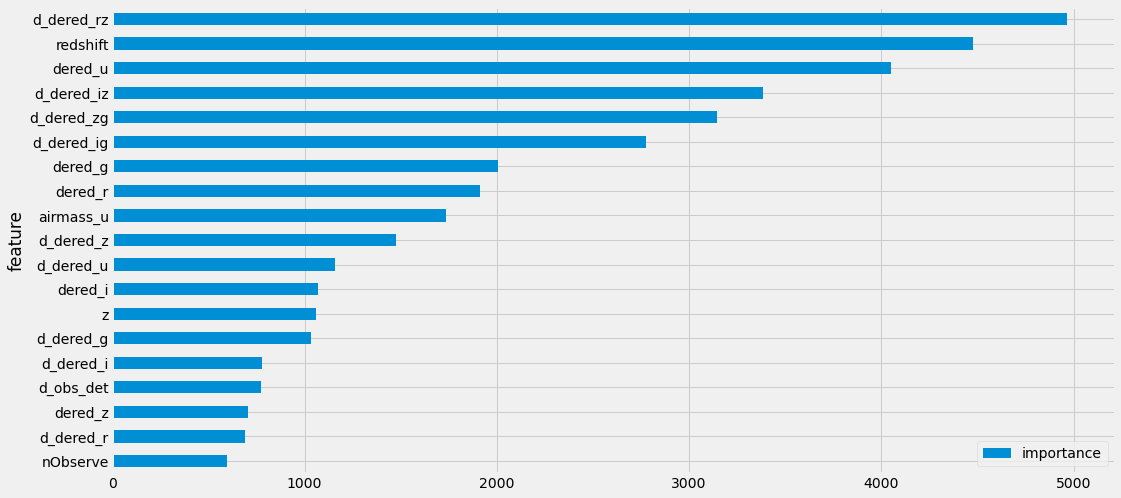

In [36]:
imp = pd.DataFrame({'feature': trn.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## Submission file creation

In [37]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [38]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [39]:
sub[target_col].value_counts()

2    41086
0    29980
1     8934
Name: class, dtype: int64

In [40]:
sub.to_csv(sub_file)

## Optuna
### Settings

### LightGBM Training

In [52]:
algo_name = 'lgb_optuna'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [56]:
import optuna.integration.lightgbm as lgb

### Hyperparameter Tuning

In [57]:
params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 3,
    'n_estimators': 1000,
    'subsample_freq': 1,
    'lambda_l1': 0.,
    'lambda_l2': 0.,
    'random_state': seed,
    'n_jobs': -1
}

In [58]:
dtrain = lgb.Dataset(X_trn, label=y_trn)
dval = lgb.Dataset(X_val, label=y_val)

model = lgb.train(params, dtrain, valid_sets=[dtrain, dval],
                  verbose_eval=100, early_stopping_rounds=10)

prediction = np.argmax(model.predict(X_val, num_iteration=model.best_iteration), axis=1)
accuracy = accuracy_score(y_val, prediction)

params = model.params
print('Best params: ', params)
print(' Accuracy = {}'.format(accuracy))
print(' Params: ')
for key, value in params.items():
    print('     {}: {}'.format(key, value))

M] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[106]	valid_0's multi_logloss: 0.113119	valid_1's multi_logloss: 0.162353
min_data_in_leaf, val_score: 0.161716:  40%|####      | 2/5 [00:34<00:53, 17.98s/it][LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM]

### Stratified K-Fold Cross Validation

In [59]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

### LightGBM Training

In [60]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))

for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = LGBMClassifier(**params)
    clf.fit(np.array(trn.iloc[i_trn,:]), y[i_trn],
            eval_set=[(np.array(trn.iloc[i_val,:]), y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)

    p_val[i_val, :] = clf.predict_proba(np.array(trn.iloc[i_val, :]))
    p_tst += clf.predict_proba(tst) / n_fold

rrent value: lambda_l2=0.9157533279257706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 0.856015
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.753732
[3]	valid_0's multi_logloss: 0.668911
[4]	valid_0's multi_logloss: 0.59771
[5]	valid_0's multi_logloss: 0.541011
[6]	valid_0's multi_logloss: 0.500282
[7]	valid_0's multi_logloss: 0.46399
[8]	valid_0's multi_logloss: 0.436612
[9]	valid_0's multi_logloss: 0.408712
[10]	valid_0's multi_logloss: 0.381009
[11]	valid_0's multi_logloss: 0.356498
[12]	valid_0's multi_logloss: 0.336217
[13]	valid_0's multi_logloss: 0.318085
[14]	valid_0's multi_logloss: 0.303479
[15]	valid_0's multi_logloss: 0.291363
[16]	valid_0's multi_logloss: 0.278618
[17]	valid_0's multi_logloss: 0.267705
[18]	valid_0's multi_logloss: 0.257506
[19]	valid_0's multi_logloss: 0.248985
[20]	valid_0's multi_logloss: 0.241985
[21]	valid_0's multi

In [68]:
print(f'{accuracy_score(y, np.argmax(p_val,axis=1))*100:.4f}%')

93.2700%


In [69]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

### Feature importance Visualization

<AxesSubplot:ylabel='feature'>

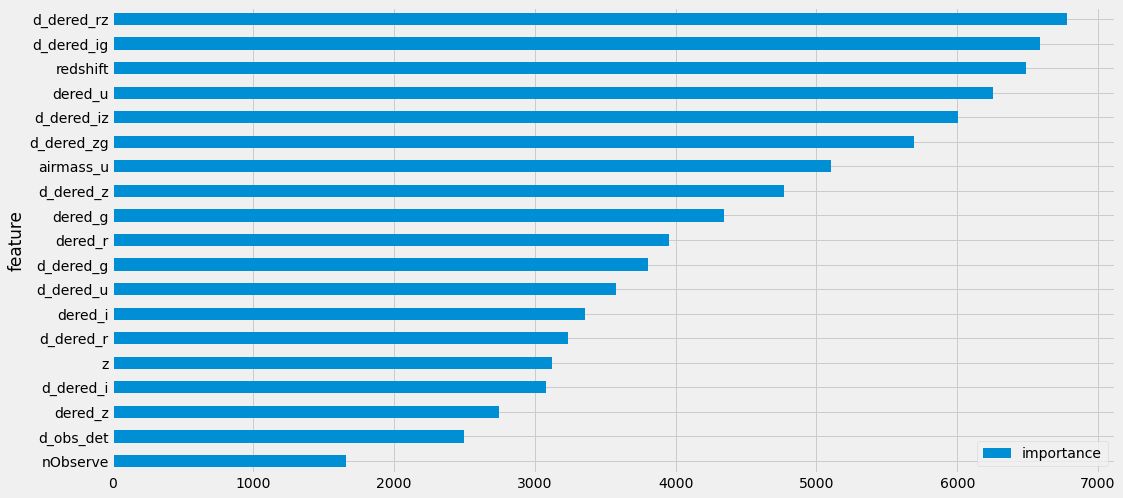

In [70]:
imp = pd.DataFrame({'feature': trn.columns, 'importance':clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

### Save File Creation

In [71]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [72]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [73]:
sub[target_col].value_counts()

2    41041
0    29970
1     8989
Name: class, dtype: int64

In [74]:
sub.to_csv(sub_file)